## VR Training analysis

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import itertools

## Dataframe creation

In [ ]:
# Import dataframe
combined_df = pd.read_csv("data/processed/combined_df.csv", index_col="Unnamed: 0")
combined_df.head()

,HRV_MeanNN,HRV_SDNN,HRV_MinNN,HRV_MaxNN,HRV_SDSD,HRV_RMSSD,HRV_pNN20,HRV_pNN50,HRV_MadNN,HRV_SD1,...,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_SD2SD1,gender,group,instrument_type
0,430.919274,45.235213,347.65625,1535.15625,37.078145,37.072622,3.490453,2.237470,23.165625,26.218208,...,856.169818,943.751380,0.006049,0.003118,0.000449,6.941327,1.513947,1,1,2
1,366.206185,18.820149,335.93750,800.78125,13.972460,13.970843,0.950174,0.811124,11.582812,9.880021,...,861.894585,961.836415,0.007696,0.004401,0.000684,6.430302,1.487255,1,1,2
2,985.799036,599.767773,304.68750,7300.78125,780.955261,780.687447,94.092219,89.841499,422.772656,552.218761,...,2321.070359,2426.545654,0.007616,0.003934,0.000162,24.272157,1.630895,2,2,2
3,430.870912,50.404025,355.46875,792.96875,34.621108,34.606484,7.341772,5.063291,46.331250,24.480820,...,2801.719606,2982.540015,0.003414,0.002308,0.000096,24.108758,1.590500,2,1,1
4,1053.975592,556.814960,316.40625,3507.81250,702.861816,702.445307,93.964497,90.532544,480.686719,496.998356,...,2263.318792,2355.220049,0.008665,0.003844,0.000227,16.959128,1.641319,2,1,1


In [3]:
# Check features
print(combined_df.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'session', 'heart_rate', 'min_hr', 'max_hr', 'ID',
       'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF',
       'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group',
       'instrument_type'],
      dtype='object')


In [9]:
combined_df_sub = combined_df.drop(columns=["HRV_MeanNN", 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S','RRV_SDSD'])
combined_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 44
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HRV_SDNN         45 non-null     float64
 1   HRV_RMSSD        45 non-null     float64
 2   HRV_pNN20        45 non-null     float64
 3   HRV_pNN50        45 non-null     float64
 4   HRV_SD1SD2       45 non-null     float64
 5   HRV_VLF          45 non-null     float64
 6   HRV_LF           45 non-null     float64
 7   HRV_HF           45 non-null     float64
 8   HRV_LFHF         45 non-null     float64
 9   session          45 non-null     object 
 10  heart_rate       45 non-null     float64
 11  min_hr           45 non-null     float64
 12  max_hr           45 non-null     float64
 13  ID               45 non-null     object 
 14  RSP_Rate_Mean    44 non-null     float64
 15  RRV_RMSSD        44 non-null     float64
 16  RRV_SDBB         44 non-null     float64
 17  RRV_VLF          44 non

### Focus on the following "supposedly" robust metrics:
- Heart rate
- SDNN
- LF/HF
- HRV SD1/SD2

- Respiration rate
- SDBB
- RMSSD
- RRV LF/HF



### Dataframe creation for visualization

In [5]:
# Inspect column names
combined_df_sub.columns

Index(['HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_SD1SD2',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'session', 'heart_rate',
       'min_hr', 'max_hr', 'ID', 'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1', 'gender',
       'group', 'instrument_type'],
      dtype='object')

In [10]:
# Remapping binary variables' numeric values to strings 
combined_visual = combined_df_sub.copy()
combined_visual["group"] = combined_visual["group"].map({1: "exp", 2: "ctr"})
combined_visual2 = combined_visual.copy()
combined_visual2["session"] = combined_visual2["session"].map({"rs": "Resting state", "bl": "Baseline", "exam": "Exam"})
combined_visual2[["ID", "heart_rate", "session", "gender", "group"]].head(5)

,ID,heart_rate,session,gender,group
0,vrt02,139.315715,Exam,1,exp
1,vrt03,163.872156,Exam,1,exp
2,vrt05,64.436496,Exam,2,ctr
3,vrt06,139.369954,Exam,2,exp
4,vrt07,59.882401,Exam,2,exp


### Subset combined dataframe to separate RRV and HRV dataframes - for different filtering and analysis

In [7]:
combined_visual2.columns

Index(['HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_SD1SD2',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'session', 'heart_rate',
       'min_hr', 'max_hr', 'ID', 'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1', 'gender',
       'group', 'instrument_type'],
      dtype='object')

In [11]:
# Create hrv dataframe
hrv_data = combined_visual2[["ID", "session", "gender", "group", "instrument_type", "heart_rate", "min_hr", "max_hr", "HRV_SDNN", "HRV_SD1SD2", "HRV_LFHF"]]

# Create rrv dataframe
rrv_data = combined_visual2[["ID", "session", "gender", "group", "instrument_type", "RSP_Rate_Mean", "RRV_SDBB", "RRV_RMSSD", "RRV_LFHF"]]

### Filtering hrv data

In [11]:
# Check heart rate values
hrv_data["heart_rate"].describe()

count     45.000000
mean      92.086745
std       29.551678
min       55.237503
25%       68.523755
50%       79.173517
75%      104.690314
max      163.872156
Name: heart_rate, dtype: float64

In [12]:
hrv_data[["ID", "session", "group", "heart_rate", "min_hr", "max_hr"]]

,ID,session,group,heart_rate,min_hr,max_hr
0,vrt02,Exam,exp,139.315715,39.083969,172.584270
1,vrt03,Exam,exp,163.872156,74.926829,178.604651
2,vrt05,Exam,ctr,64.436496,8.218299,196.923077
3,vrt06,Exam,exp,139.369954,75.665025,168.791209
4,vrt07,Exam,exp,59.882401,17.104677,189.629630
5,vrt08,Exam,ctr,78.196490,19.009901,196.923077
6,vrt10,Exam,ctr,139.114691,41.513514,279.272727
7,vrt11,Exam,ctr,135.419894,99.740260,156.734694
8,vrt12,Exam,exp,126.086591,34.133333,196.923077
9,vrt14,Exam,exp,153.444485,55.854545,176.551724


Akkora baromságok vannak benne, hogy inkább kiírom egyesével a Hexoskin dashboardból a hr, min_hr, max_hr értékeket.

In [13]:
# Create dictionary with hr and hr min-max values from hexoskin dashboard
HR = {"HR": [141, 164, 91, 140, 87, 169, 152, 136, 142, 157, 139, 121, 88, 91, 103, 105, 90, 86, 98, 78, 148, 101, 95, 85, 108, 121, 87, 85, 92, 100, 79, 75, 69, 78, 98, 118, 63, 85, 71, 67, 105, 106, 91, 85, 97]
      }

HRmin = {"HRmin": [106, 142, 55, 111, 51, 116, 125, 121, 86, 139, 105, 57, 54, 54, 53, 85, 80, 66, 82, 46, 125, 77, 80, 70, 70, 96, 61, 51, 63, 89, 67, 68, 62, 73, 54, 106, 59, 78, 61, 60, 98, 93, 62, 64, 89]
}

HRmax = {"HRmax": [165, 178, 149, 162, 156, 184, 175, 153, 161, 174, 162, 176, 152, 151, 154, 149, 103, 126, 111, 125, 164, 120, 105, 120, 136, 140, 124, 134, 138, 113, 115, 100, 89, 82, 152, 131, 70, 94, 86, 79, 113, 131, 123, 118, 107]
         }


# rs_mean = [79, 75, 69, 78, 98, 118, 63, 85, 71, 67, 105, 106, 91, 85, 97]
# rs_min = [67, 68, 62, 73, 54, 106, 59, 78, 61, 60, 98, 93, 62, 64, 89]
# rs_max = [115, 100, 89, 82, 152, 131, 70, 94, 86, 79, 113, 131, 123, 118, 107] 

In [14]:
heart_rate_hexo = hrv_data[["ID", "session", "group", "heart_rate"]]
heart_rate_hexo["HR"] = HR["HR"]
heart_rate_hexo["HRmin"] = HRmin["HRmin"]
heart_rate_hexo["HRmax"] = HRmax["HRmax"]

C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\411010777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_hexo["HR"] = HR["HR"]
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\411010777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_hexo["HRmin"] = HRmin["HRmin"]
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\411010777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [15]:
hrv_data2 = hrv_data.merge(heart_rate_hexo, on=["ID", "session", "group", "heart_rate"], how="left")
hrv_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               45 non-null     object 
 1   session          45 non-null     object 
 2   gender           45 non-null     int64  
 3   group            45 non-null     object 
 4   instrument_type  45 non-null     int64  
 5   heart_rate       45 non-null     float64
 6   min_hr           45 non-null     float64
 7   max_hr           45 non-null     float64
 8   HRV_SDNN         45 non-null     float64
 9   HRV_SD1SD2       45 non-null     float64
 10  HRV_LFHF         45 non-null     float64
 11  HR               45 non-null     int64  
 12  HRmin            45 non-null     int64  
 13  HRmax            45 non-null     int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ KB


In [16]:
hrv_data3 = hrv_data2.drop(columns=["heart_rate", "min_hr", "max_hr"])

#### I used Hexoskin's heart rate values, because they seemed more realistic. But, I calculated the HRV metrics with Neurokit2, based on the raw data 

### Filtering rrv data

In [17]:
# Check missing values
print(rrv_data.isnull().sum())

print("\n")
print("IDs with missing values: ")
# Find the IDs with missing values
print(rrv_data[rrv_data.isnull().any(axis=1)]["ID"])

ID                 0
session            0
gender             0
group              0
instrument_type    0
RSP_Rate_Mean      1
RRV_SDBB           1
RRV_RMSSD          1
RRV_LFHF           1
dtype: int64


IDs with missing values: 
18    vrt06
Name: ID, dtype: object


In [18]:
# Filter out vrt06
rrv_data2 = rrv_data[rrv_data["ID"] != "vrt06"]

# Check for misisng values
rrv_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 44
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               42 non-null     object 
 1   session          42 non-null     object 
 2   gender           42 non-null     int64  
 3   group            42 non-null     object 
 4   instrument_type  42 non-null     int64  
 5   RSP_Rate_Mean    42 non-null     float64
 6   RRV_SDBB         42 non-null     float64
 7   RRV_RMSSD        42 non-null     float64
 8   RRV_LFHF         42 non-null     float64
dtypes: float64(4), int64(2), object(3)
memory usage: 3.3+ KB


## Plot the raw data

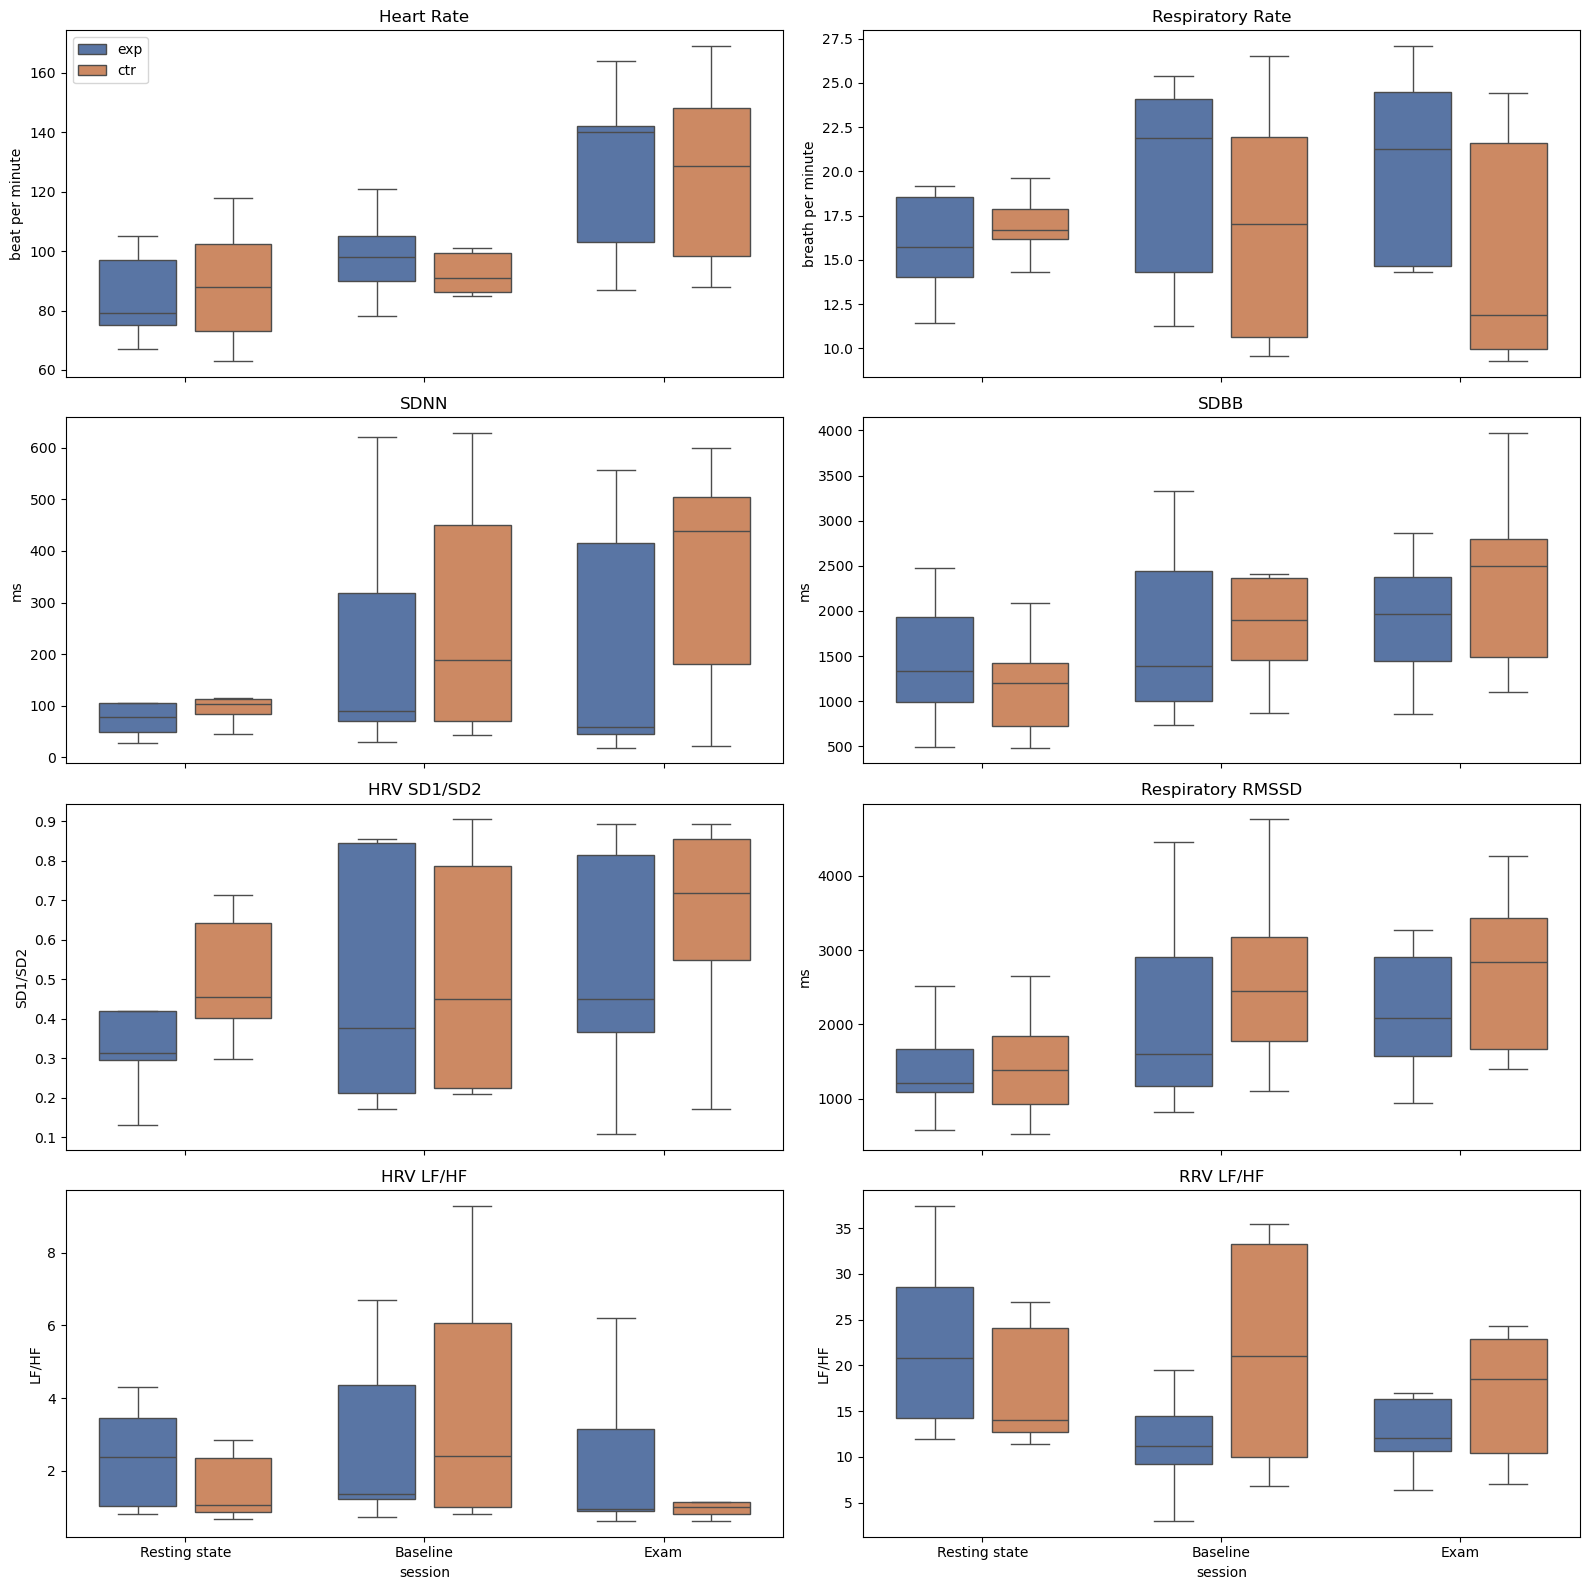

In [31]:
# Visualize all the raw metrics in focus
# filtered hrv data = hrv_data3, filtered rrv data = rrv_data2
# Create subplots 4 rows, 2 columns (HRV and RRV)
fig, axes = plt.subplots(4, 2, figsize=(16, 16), sharex=True)

order = ["Resting state", "Baseline", "Exam"]

# heart rate
sns.boxplot(
    data=hrv_data3, 
    x="session", 
    y="HR", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[0, 0],
    showfliers=False
)

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0, 1), frameon=True, fancybox=True)
axes[0, 0].set_ylabel("beat per minute")
axes[0, 0].set_title("Heart Rate")

# respiration rate
sns.boxplot(
    data=rrv_data2, 
    x="session", 
    y="RSP_Rate_Mean", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[0, 1],
    showfliers=False
)

axes[0, 1].legend().remove()
axes[0, 1].set_ylabel("breath per minute")
axes[0, 1].set_title("Respiratory Rate")

# SDNN
sns.boxplot(
    data=hrv_data3, 
    x="session", 
    y="HRV_SDNN", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[1, 0],
    showfliers=False
)

axes[1, 0].legend().remove()
axes[1, 0].set_ylabel("ms")
axes[1, 0].set_title("SDNN")

# SDBB
sns.boxplot(
    data=rrv_data2, 
    x="session", 
    y="RRV_SDBB", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[1, 1],
    showfliers=False
)

axes[1, 1].legend().remove()
axes[1, 1].set_ylabel("ms")
axes[1, 1].set_title("SDBB")

# RRV RMSSD
sns.boxplot(
    data=rrv_data2, 
    x="session", 
    y="RRV_RMSSD", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[2, 1],
    showfliers=False
)

axes[2, 1].legend().remove()
axes[2, 1].set_ylabel("ms")
axes[2, 1].set_title("Respiratory RMSSD")

# HRV SD1SD2
sns.boxplot(
    data=hrv_data3, 
    x="session", 
    y="HRV_SD1SD2", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[2, 0],
    showfliers=False
)

axes[2, 0].legend().remove()
axes[2, 0].set_ylabel("SD1/SD2")
axes[2, 0].set_title("HRV SD1/SD2")

# HRV LF/HF
sns.boxplot(
    data=hrv_data3, 
    x="session", 
    y="HRV_LFHF", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[3, 0],
    showfliers=False
)

axes[3, 0].legend().remove()
axes[3, 0].set_ylabel("LF/HF")
axes[3, 0].set_title("HRV LF/HF")

# RRV LF/HF
sns.boxplot(
    data=rrv_data2, 
    x="session", 
    y="RRV_LFHF", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[3, 1],
    showfliers=False
)

axes[3, 1].legend().remove()
axes[3, 1].set_ylabel("LF/HF")
axes[3, 1].set_title("RRV LF/HF")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Calculate descriptive statistics


In [20]:
# Create function for df manipulation and recreation
def data_formatting(df, metric):
    # For baseline session
    bl = df.loc[df["session"] == "Baseline"].copy()
    bl.rename(columns={metric: "Baseline"}, inplace=True)
    bl = bl[["ID", "instrument_type", "group", "Baseline"]]

    # For resting state session
    rs = df.loc[df["session"] == "Resting state"].copy()
    rs.rename(columns={metric: "Resting state"}, inplace=True)
    rs = rs[["ID", "instrument_type", "group", "Resting state"]]
        
    # For exam session
    exam = df.loc[df["session"] == "Exam"].copy()
    exam.rename(columns={metric: "Exam"}, inplace=True)
    exam = exam[["ID", "instrument_type", "group", "Exam"]]

    # Merge dataframes
    merged_df = pd.merge(left=exam, right=bl, on=["ID", "instrument_type", "group"], how="left")
    merged_df = pd.merge(left=merged_df, right=rs, on=["ID", "instrument_type", "group"], how="left")
    
    # return the transformed df
    return merged_df

In [21]:
# Copy the filtered dataframes
hrv_data4  = hrv_data3.copy()
rrv_data3 = rrv_data2.copy()
# Reformat dataframes to wide format: each metric to a new dataframe, exam, bl and rs in a separate column
meanHR_df = data_formatting(hrv_data4, "HR")
HRV_SDNN_df = data_formatting(hrv_data4, "HRV_SDNN")
sd1sd2_df = data_formatting(hrv_data4, "HRV_SD1SD2")
RSP_df = data_formatting(rrv_data3, "RSP_Rate_Mean")
SDBB_df = data_formatting(rrv_data3, "RRV_SDBB")
RRV_RMSSD_df = data_formatting(rrv_data3, "RRV_RMSSD")
HRV_LFHF_df = data_formatting(hrv_data4, "HRV_LFHF")
RRV_LFHF_df = data_formatting(rrv_data3, "RRV_LFHF")

# Isnpect one of the resulted dfs
meanHR_df.head()

,ID,instrument_type,group,Exam,Baseline,Resting state
0,vrt02,2,exp,141,105,79
1,vrt03,2,exp,164,90,75
2,vrt05,2,ctr,91,86,69
3,vrt06,1,exp,140,98,78
4,vrt07,1,exp,87,78,98


In [22]:
# Create descriptive tables for further table creation
HR_desc = meanHR_df.groupby(by="group").describe().round(2)
SDNN_desc = HRV_SDNN_df.groupby(by="group").describe().round(2)
RSP_desc = RSP_df.groupby(by="group").describe().round(2)
SDBB_desc = SDBB_df.groupby(by="group").describe().round(2)
RMSSD_desc = RRV_RMSSD_df.groupby(by="group").describe().round(2)
sd1sd2_desc = sd1sd2_df.groupby(by="group").describe().round(2)
HRV_LFHF_desc = HRV_LFHF_df.groupby(by="group").describe().round(2)
RRV_LFHF_desc = RRV_LFHF_df.groupby(by="group").describe().round(2)

In [23]:
# Test df creation result
HR_desc

instrument_type                                        Exam          \
                count  mean   std  min   25%  50%  75%  max count    mean   
group                                                                       
ctr               6.0  1.67  0.52  1.0  1.25  2.0  2.0  2.0   6.0  126.17   
exp               9.0  1.56  0.53  1.0  1.00  2.0  2.0  2.0   9.0  129.33   

       ... Baseline        Resting state                                  \
       ...      75%    max         count   mean    std   min   25%   50%   
group  ...                                                                 
ctr    ...     99.5  148.0           6.0  88.67  21.10  63.0  73.0  88.0   
exp    ...    105.0  121.0           9.0  83.89  13.26  67.0  75.0  79.0   

                      
          75%    max  
group                 
ctr    102.25  118.0  
exp     97.00  105.0  

[2 rows x 32 columns]

In [24]:
# By ChatGPT
# Extracting the required descriptive statistics (mean, std, min, max) for 'bl' and 'exam'
HR_stats = HR_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
SDNN_stats = SDNN_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
sd1sd2_stats = sd1sd2_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
RSP_stats = RSP_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
SDBB_stats = SDBB_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
RMSSD_stats = RMSSD_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
HRV_LFHF_stats = HRV_LFHF_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]
RRV_LFHF_stats = RRV_LFHF_desc.loc[:, (["Resting state", "Baseline", "Exam"], ['mean', 'std', 'min', 'max'])]



# Adding a 'Metric' level to each DataFrame
HR_stats['Metric'] = 'Heart rate'
SDNN_stats['Metric'] = 'HRV SDNN'
sd1sd2_stats['Metric'] = 'HRV SD1/SD2'
RSP_stats['Metric'] = 'Respiratory Rate'
SDBB_stats['Metric'] = 'SDBB'
RMSSD_stats['Metric'] = 'RRV RMSSD'
HRV_LFHF_stats["Metric"] = "HRV LFHF"
RRV_LFHF_stats["Metric"] = "RRV LFHF"

# Concatenating all DataFrames into one
df_stats = pd.concat([HR_stats, SDNN_stats, sd1sd2_stats, RSP_stats, SDBB_stats, RMSSD_stats, HRV_LFHF_stats, RRV_LFHF_stats])

# Set 'Metric' and 'group' as multi-index
df_stats = df_stats.set_index(['Metric'], append=True).swaplevel(0, 1).sort_index()


C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\2138031281.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HR_stats['Metric'] = 'Heart rate'
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\2138031281.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDNN_stats['Metric'] = 'HRV SDNN'
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_14752\2138031281.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [25]:
# Test df creation results
df_stats

Resting state                          Baseline  \
                                mean     std     min      max     mean   
Metric           group                                                   
HRV LFHF         ctr            1.54    1.00    0.69     2.86     3.79   
                 exp            2.32    1.27    0.82     4.31     3.30   
HRV SD1/SD2      ctr            0.50    0.17    0.30     0.71     0.51   
                 exp            0.42    0.26    0.13     0.86     0.48   
HRV SDNN         ctr          123.37   87.31   45.55   294.23   269.57   
                 exp          190.32  247.61   26.96   703.49   221.30   
Heart rate       ctr           88.67   21.10   63.00   118.00   100.33   
                 exp           83.89   13.26   67.00   105.00    97.44   
RRV LFHF         ctr           27.31   28.68   11.37    84.69    21.33   
                 exp           27.42   21.23   11.92    75.42    11.44   
RRV RMSSD        ctr         1451.60  780.36  519.91  2658.40  2623.56   
                 exp         1406.07  619.39  582.26  2515.27  2098.51   
Respiratory Rate ctr           16.94    1.83   14.33    19.64    17.04   
                 exp           15.87    2.78   11.43    19.19    19.67   
SDBB             ctr         1174.00  592.22  484.50  2091.83  2067.33   
                 exp         1440.80  657.90  487.80  2480.28  1741.27   

                                                      Exam                    \
                            std      min      max     mean      std      min   
Metric           group                                                         
HRV LFHF         ctr       3.57     0.80     9.28     1.74     2.03     0.62   
                 exp       3.16     0.72     9.89     2.51     2.73     0.62   
HRV SD1/SD2      ctr       0.32     0.21     0.90     0.65     0.28     0.17   
                 exp       0.30     0.17     0.85     0.52     0.29     0.11   
HRV SDNN         ctr     249.02    43.99   628.96   353.57   234.97    22.03   
                 exp     218.32    30.78   620.75   202.66   218.09    18.82   
Heart rate       ctr      24.16    85.00   148.00   126.17    32.62    88.00   
                 exp      12.98    78.00   121.00   129.33    28.34    87.00   
RRV LFHF         ctr      13.37     6.78    35.41    20.19    13.84     7.05   
                 exp       4.95     3.00    19.54    12.41     4.14     6.43   
RRV RMSSD        ctr    1323.85  1108.61  4760.97  2713.11  1166.11  1405.44   
                 exp    1285.68   820.75  4459.71  2139.57   918.53   943.00   
Respiratory Rate ctr       7.17     9.56    26.54    15.28     7.23     9.29   
                 exp       5.50    11.30    25.37    20.33     5.40    14.34   
SDBB             ctr    1060.13   871.64  3904.02  2354.55  1080.44  1105.73   
                 exp     964.63   738.97  3332.30  1890.75   770.17   856.17   

                                 
                            max  
Metric           group           
HRV LFHF         ctr       5.86  
                 exp       7.94  
HRV SD1/SD2      ctr       0.89  
                 exp       0.89  
HRV SDNN         ctr     599.77  
                 exp     556.81  
Heart rate       ctr     169.00  
                 exp     164.00  
RRV LFHF         ctr      44.93  
                 exp      16.96  
RRV RMSSD        ctr    4272.91  
                 exp    3275.24  
Respiratory Rate ctr      24.46  
                 exp      27.08  
SDBB             ctr    3974.56  
                 exp    2858.73

In [26]:
# Rename "Respiratory Rate" to "Respiratory rate" so that it aligns with "Heart rate"
df_stats_renamed = df_stats.rename(index={"Respiratory Rate": "Respiratory rate"})

# Reorder row indices
# Reorder the row index
appropriate_order = [
    "Heart rate",
    "HRV SDNN",
    "HRV SD1/SD2",
    "HRV LFHF",
    "Respiratory rate",
    "SDBB",
    "RRV RMSSD",
    "RRV LFHF"
]

# Reindex with the desired order for the first level (Metric)
df_stats2 = df_stats_renamed.loc[appropriate_order]


# Sanity check
print(len(df_stats2))

# Display the final dataframe
df_stats2

16


Resting state                          Baseline  \
                                mean     std     min      max     mean   
Metric           group                                                   
Heart rate       ctr           88.67   21.10   63.00   118.00   100.33   
                 exp           83.89   13.26   67.00   105.00    97.44   
HRV SDNN         ctr          123.37   87.31   45.55   294.23   269.57   
                 exp          190.32  247.61   26.96   703.49   221.30   
HRV SD1/SD2      ctr            0.50    0.17    0.30     0.71     0.51   
                 exp            0.42    0.26    0.13     0.86     0.48   
HRV LFHF         ctr            1.54    1.00    0.69     2.86     3.79   
                 exp            2.32    1.27    0.82     4.31     3.30   
Respiratory rate ctr           16.94    1.83   14.33    19.64    17.04   
                 exp           15.87    2.78   11.43    19.19    19.67   
SDBB             ctr         1174.00  592.22  484.50  2091.83  2067.33   
                 exp         1440.80  657.90  487.80  2480.28  1741.27   
RRV RMSSD        ctr         1451.60  780.36  519.91  2658.40  2623.56   
                 exp         1406.07  619.39  582.26  2515.27  2098.51   
RRV LFHF         ctr           27.31   28.68   11.37    84.69    21.33   
                 exp           27.42   21.23   11.92    75.42    11.44   

                                                      Exam                    \
                            std      min      max     mean      std      min   
Metric           group                                                         
Heart rate       ctr      24.16    85.00   148.00   126.17    32.62    88.00   
                 exp      12.98    78.00   121.00   129.33    28.34    87.00   
HRV SDNN         ctr     249.02    43.99   628.96   353.57   234.97    22.03   
                 exp     218.32    30.78   620.75   202.66   218.09    18.82   
HRV SD1/SD2      ctr       0.32     0.21     0.90     0.65     0.28     0.17   
                 exp       0.30     0.17     0.85     0.52     0.29     0.11   
HRV LFHF         ctr       3.57     0.80     9.28     1.74     2.03     0.62   
                 exp       3.16     0.72     9.89     2.51     2.73     0.62   
Respiratory rate ctr       7.17     9.56    26.54    15.28     7.23     9.29   
                 exp       5.50    11.30    25.37    20.33     5.40    14.34   
SDBB             ctr    1060.13   871.64  3904.02  2354.55  1080.44  1105.73   
                 exp     964.63   738.97  3332.30  1890.75   770.17   856.17   
RRV RMSSD        ctr    1323.85  1108.61  4760.97  2713.11  1166.11  1405.44   
                 exp    1285.68   820.75  4459.71  2139.57   918.53   943.00   
RRV LFHF         ctr      13.37     6.78    35.41    20.19    13.84     7.05   
                 exp       4.95     3.00    19.54    12.41     4.14     6.43   

                                 
                            max  
Metric           group           
Heart rate       ctr     169.00  
                 exp     164.00  
HRV SDNN         ctr     599.77  
                 exp     556.81  
HRV SD1/SD2      ctr       0.89  
                 exp       0.89  
HRV LFHF         ctr       5.86  
                 exp       7.94  
Respiratory rate ctr      24.46  
                 exp      27.08  
SDBB             ctr    3974.56  
                 exp    2858.73  
RRV RMSSD        ctr    4272.91  
                 exp    3275.24  
RRV LFHF         ctr      44.93  
                 exp      16.96

In [27]:
# Save table for publication in csv format
df_stats2.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/table_desc.csv", index=True)

## Modeling

### Conduct Linear Mixed-Effects Modeling
- Create a model for each metric

In [180]:
# Check column names for reference in the modeling 
hrv_data3.columns

Index(['ID', 'session', 'gender', 'group', 'instrument_type', 'HRV_SDNN',
       'HRV_SD1SD2', 'HRV_LFHF', 'HR', 'HRmin', 'HRmax'],
      dtype='object')

#### Create convenient functions for use in each model

In [ ]:
# Function for visualizing residuals vs fitted values and QQ plot
def resid_vis(model):
    """
    Function to visualize residuals vs fitted fitted values and
    QQ plot of standardized residuals.
    """
    # Get the residuals
    resid = model.resid
    std_resid = resid / resid.std()
    fitted = model.fittedvalues

    # Plot: Residuals vs. Fitted
    plt.figure(figsize=(12, 6))
    plt.scatter(fitted, std_resid)
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(2.5, color='red', linestyle='--')
    plt.axhline(-2.5, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Standardized Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    # Plot: QQ Plot
    sm.qqplot(std_resid, line='45')
    plt.title("QQ Plot of Standardized Residuals")
    plt.show()

# Calculate covariance matrix
def cov_matrix(model_result):  
    # Random effects covariance matrix
    print("Random Effects Covariance Matrix:")
    print(model_result.cov_re)

    # Standard deviation of random effects
    print("\nRandom Effects Std Devs:")
    print(model_result.random_effects) 

#################### NOT USED ###################
# Function to standardize the DV
def standardize_dv(data, metric):
    # Instantiate the scaler
    scaler = StandardScaler()
    
    # Create a new column for the standardized metric and apply the scaler
    data["std_" + metric] = scaler.fit_transform(data[[metric]])
    
    return data

#### Assumption checks

In [ ]:
# Normality check on unstandardized dependent variables

# List of metrics and data source
metrics_hrv = ["HR", "HRV_SDNN", "HRV_SD1SD2", "HRV_LFHF"]
metrics_rrv = ["RSP_Rate_Mean", "RRV_SDBB", "RRV_RMSSD", "RRV_LFHF"]

# Initialize empty list to collect DataFrames
normality_dfs = []

# Loop over hrv metrics
for metric in metrics_hrv:
    # Run normality test
    norm = pg.normality(data=hrv_data3, 
                        dv=metric, 
                        group="group", 
                        method="shapiro")

    # Unpack multiIndex
    norm = norm.reset_index()

    # Add metric name
    norm["metric"] = metric

    # Reorder columns for consistency
    ordered_cols = ["metric"] + [col for col in norm.columns if col not in ["metric"]]
    norm = norm[ordered_cols]

    # Append to list
    normality_dfs.append(norm)

# Loop over rrv metrics
for metric in metrics_rrv:
    # Run normality test
    norm = pg.normality(data=rrv_data2, 
                        dv=metric, 
                        group="group", 
                        method="shapiro")

    # Unpack MultiIndex if present
    norm = norm.reset_index()

    # Add metric name
    norm["metric"] = metric

    # Reorder columns for consistency
    ordered_cols = ["metric"] + [col for col in norm.columns if col not in ["metric"]]
    norm = norm[ordered_cols]

    # Append to list
    normality_dfs.append(norm)

# Combine all into a single DataFrame
normality_df = pd.concat(normality_dfs, ignore_index=True)

# Set multiIndex
normality_df.set_index(["metric", "group"], inplace=True)

# Print or return the final DataFrame
normality_df


W      pval  normal
metric        group                            
HR            exp    0.904295  0.016795   False
              ctr    0.912561  0.095467    True
HRV_SDNN      exp    0.769528  0.000042   False
              ctr    0.839095  0.005727   False
HRV_SD1SD2    exp    0.861056  0.001922   False
              ctr    0.917470  0.116599    True
HRV_LFHF      exp    0.793325  0.000105   False
              ctr    0.703409  0.000088   False
RSP_Rate_Mean exp    0.913127  0.041253   False
              ctr    0.929643  0.191404    True
RRV_SDBB      exp    0.945537  0.216436    True
              ctr    0.926688  0.169767    True
RRV_RMSSD     exp    0.910376  0.035939   False
              ctr    0.948142  0.396614    True
RRV_LFHF      exp    0.638672  0.000002   False
              ctr    0.766138  0.000525   False

In [222]:
# List of metrics and data source
metrics_hrv = ["HR", "HRV_SDNN", "HRV_SD1SD2", "HRV_LFHF"]
metrics_rrv = ["RSP_Rate_Mean", "RRV_SDBB", "RRV_RMSSD", "RRV_LFHF"]

# Initialize empty list to collect DataFrames
homoscedasceity_dfs = []

# Loop through HRV metrics
for metric in metrics_hrv:
      hs = pg.homoscedasticity(data=hrv_data3,
                    dv=metric,
                    group="group",
                    method="levene")
      
      # Unpack multiindex
      hs.reset_index()
      
      # Add metric name
      hs["metric"] = metric
      
      # Reorder columns for consistency
      ordered_cols = ["metric"] + [col for col in hs.columns if col not in ["metric"]]
      hs = hs[ordered_cols]
      
      # Append to list
      homoscedasceity_dfs.append(hs)

# Loop through RRV metrics
for metric in metrics_rrv:
      hs = pg.homoscedasticity(data=rrv_data2,
                    dv=metric,
                    group="group",
                    method="levene")
      
      # Unpack multiindex
      hs.reset_index(drop=True, inplace=True)
      
      # Add metric name
      hs["metric"] = metric
      
      # Reorder columns for consistency
      ordered_cols = ["metric"] + [col for col in hs.columns if col not in ["metric"]]
      hs = hs[ordered_cols]
      
      # Append to list
      homoscedasceity_dfs.append(hs)
      
# Combine all into a single DataFrame 
hs_dfs = pd.concat(homoscedasceity_dfs, ignore_index=True)

# Set multiIndex
hs_dfs.set_index("metric", inplace=True)

hs_dfs

,W,pval,equal_var
metric,,,
HR,0.105670,0.746705,True
HRV_SDNN,0.120899,0.729757,True
HRV_SD1SD2,0.001544,0.968834,True
HRV_LFHF,0.115398,0.735734,True
RSP_Rate_Mean,0.280690,0.599178,True
RRV_SDBB,0.620408,0.435538,True
RRV_RMSSD,0.633268,0.430856,True
RRV_LFHF,1.327743,0.256047,True


Move these two cells to the bottom

In [ ]:
#################### OLDER VERSION, NOT USED. LEFT HERE FOR THE DATAFRAME SOURCE ######################
# Save table
gee_results_df.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/gee_results.csv", index=False)

In [ ]:
####################### OLDER VERION, NOT USED ########################
####################### LEFT HERE REFERENCE ########################
# List of the metrics to analyze
metrics_hrv = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF"]

metrics_rrv = ["RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]
# Empty dictionary to store the results
p_values = {}

"""
    I had to create two separate dataframes to loop through, because vrt06 had no respiratory data
    and I had to drop her from the RRV analysis
"""
# Drop vrt06 for RRV analysis
combined_rrv = hrv_valid[hrv_valid["ID"] != "vrt06"]

# Loop through each HRV  metric
for metric in metrics_hrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_hrv = smf.mixedlm(
        f"{metric} ~ C(session) * C(group) + C(instrument_type)",  # Fixed effects, setting session, group and instrument_type for dummy coding
        data=hrv_valid,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_hrv_result = lmm_hrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
    # and interaction effects: session x group
"""    p_values[metric] = {
        'session': lmm_hrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_hrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_hrv_result.pvalues['instrument_type[T.2]'].round(2),
        'session:group': lmm_hrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }
"""
# Loop through each RRV  metric
for metric in metrics_rrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_rrv = smf.mixedlm(
        f"{metric} ~ C(session) * C(group) + C(instrument_type)",  # Fixed effects, setting session, group and instrument_type for dummy coding
        data=combined_rrv,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_rrv_result = lmm_rrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
"""    p_values[metric] = {
        'session': lmm_rrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_rrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_rrv_result.pvalues['instrument_type[T.2]'].round(2),
        'session:group': lmm_rrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }

"""

# Convert the results into a DataFrame for easier viewing
# lmm_p_values_df = pd.DataFrame(p_values)


### Workflow

For modeling we will follow this workflow:
1. Conduct LMM for given metric
2. Assumption check for model: visualize residuals vs fitted
    - Exclude datapoint outside 2.5 std, then refit model
3. Calculate EMMEANS
4. If results significant run post-hocs on EMMEANS
5. Calculate effect sizes from EMMEANS
6. Calculate R-squared (marginal and conditional)
7. Repeat steps for each DV

For reporting we will follow this workflow:

1. Table for fixed effects:
    - coeffs
    - SE and /or CI
    - test statistic
    - p-value
    - model fit: R-squared (marginal and conditional)
    - Converged (Yes/No)
2. Table for random effects:
    - SD (Intercept),
    - SD (Resting state vs. Baseline) 
    - SD (Exam vs. Baseline)
    - SD (Residual)
    - Corr(Int, Exam)
    - ICC


In [28]:
# Copy dataframes
hrv_data5 = hrv_data3.copy()
rrv_data4 = rrv_data2.copy()

# Transform variables to categorical
categorical_vars = ["session", "gender", "group", "instrument_type"]

for var in categorical_vars:
    if var in hrv_data5.columns:
        hrv_data5[var] = pd.Categorical(hrv_data5[var])
        
for var in categorical_vars:
    if var in rrv_data4.columns:
        rrv_data4[var] = pd.Categorical(rrv_data4[var])

In [444]:
# Create new design matrix for specific factor levels
# Based on this: https://glennwilliams.me/blog/posts/estimating-marginal-means-manually-in-python/
# Get unique levels for each factor
levels = [
    hrv_data5["session"].unique(),
    hrv_data5["group"].unique(),
    hrv_data5["instrument_type"].unique(),
    hrv_data5["gender"].unique()
]

# Create all combinations using itertools.product
grid = pd.DataFrame(list(itertools.product(*levels)),
                    columns=["session", "group", "instrument_type", "gender"])

#After generating the grid, I created a design matrix with dummy coded predictor levels 
# Needed For SE and CI
rhs_formula = "C(session) * C(group) + C(instrument_type) + C(gender)" # lmm_hr_result.model.formula.split("~", 1)[1].strip()
exog = dmatrix(rhs_formula, grid, return_type="dataframe")

In [ ]:

# Define function for repeated residuals check
def res_visual(model_result):
    # Standardized residuals
    resid = model_result.resid
    std_resid = resid / resid.std()

    # Plot: Residuals vs. Fitted
    plt.figure(figsize=(10, 5))
    plt.scatter(model_result.fittedvalues, std_resid)
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(2.5, color='red', linestyle='--')
    plt.axhline(-2.5, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Standardized Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    # Plot: QQ Plot
    sm.qqplot(std_resid, line='45')
    plt.title("QQ Plot of Standardized Residuals")
    plt.show()



In [447]:
def get_emmeans(model, grid, metric):
    """
    Based on this: https://glennwilliams.me/blog/posts/estimating-marginal-means-manually-in-python/, 
    I should have used grid["emmean"] = np.dot(exog, model.fe_params)
    
    """
    # Calculate estimated marginal mean value
    grid[metric + "_emmean"] = model.predict(grid) # Using only fixed effects
    
    # Calculate standard error
    ## Get variance -covariance matrix
    cov_params = model.cov_params()
    ## Filter out random effects variance | covariance
    cov_fixed = cov_params.iloc[:8, :8]
    ## Calculate SE
    var_pred = np.diag(exog @ cov_fixed @ exog.T)
    ## Add to grid
    grid[metric + "_emmean_SE"] = np.sqrt(var_pred)
     
    # Calculate confidence intervals
    confint = stats.norm.interval(confidence=0.95,
                              loc=grid[metric + "_emmean"],
                              scale=grid[metric + "_emmean_SE"])
    ## Add to grid
    grid[metric + "_emmean_lowerCI"] = confint[0]
    grid[metric + "_emmean_upperCI"] = confint[1]
    
    

In [557]:
################# By ChatGPT ########################
def test_contrasts(model_result, contrast_dict, alpha=0.05, correction='bonferroni'):
    """
    Perform t-tests on multiple contrasts with optional correction method.

    Parameters:
    - model_result: statsmodels MixedLMResults object
    - contrast_dict: dict of {label: contrast vector (np.array)}
    - alpha: significance level (default = 0.05)
    - correction: method for multiple testing correction
        Options: 'bonferroni', 'holm', 'fdr_bh', 'fdr_by', 'sidak', etc.

    Returns:
    - DataFrame with estimates, SEs, t-stats, CI, and corrected p-values.
    """
    results = []
    p_values = []
    # Estimate residual SD for effect size calculation
    resid_sd = np.sqrt(model_result.scale)

    for label, contrast_vec in contrast_dict.items():
        t_res = model_result.t_test(contrast_vec.reshape(1, -1))
        

        # Extract scalars
        estimate = t_res.effect.item()
        se = t_res.sd.item()
        t_stat = t_res.tvalue.item()
        p_value = t_res.pvalue.item()
        ci_low = estimate - 1.96 * se
        ci_high = estimate + 1.96 * se
        # Effect size (standardized)
        effect_size = estimate / resid_sd
        
        results.append({
            "contrast": label,
            "estimate": estimate,
            "SE": se,
            "t-stat": t_stat,
            "CI 95% lower": ci_low,
            "CI 95% upper": ci_high,
            "p-value (raw)": p_value,
            "Cohen's d": effect_size
        })
        p_values.append(p_value)

    # Apply chosen correction
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method=correction)
    for i, corrected_p in enumerate(pvals_corrected):
        results[i]["p-value ({})".format(correction)] = corrected_p
        results[i]["reject H0 ({})".format(correction)] = reject[i]

    return pd.DataFrame(results)



#### Heart rate

In [361]:
# Conduct the LMM model for heart rate
lmm_hr = mixedlm(
        "HR ~ C(session) * C(group) + C(instrument_type) + C(gender)",  # Fixed effects, setting session, group and instrument_type for dummy coding
        data=hrv_data5,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for 'session' within each subject
)

lmm_hr_result = lmm_hr.fit(method="powell", # optimization method for noisy and low signal quality 
                           disp=True, maxiter=1000)


lmm_hr_result.summary()

Optimization terminated successfully.
         Current function value: 3.697589
         Iterations: 4
         Function evaluations: 270


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM             Dependent Variable:             HR       
No. Observations:               45                  Method:                         REML     
No. Groups:                     15                  Scale:                          80.7976  
Min. group size:                3                   Log-Likelihood:                 -166.3915
Max. group size:                3                   Converged:                      Yes      
Mean group size:                3.0                                                          
---------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                       102.762   10.307  9.970 0.000  82.561 122.962
C(session)[T.Exam]                               25.833    9.730  2.655 0.008   6.762  44.905
C(session)[T.Resting state]                     -11.667    7.607 -1.534 0.125 -26.577   3.243
C(group)[T.exp]                                  -3.995    9.164 -0.436 0.663 -21.955  13.966
C(instrument_type)[T.2]                          -9.952    7.665 -1.298 0.194 -24.975   5.071
C(gender)[T.2]                                    6.310    8.034  0.785 0.432  -9.436  22.055
C(session)[T.Exam]:C(group)[T.exp]                6.056   12.562  0.482 0.630 -18.566  30.677
C(session)[T.Resting state]:C(group)[T.exp]      -1.889    9.821 -0.192 0.847 -21.137  17.360
ID Var                                          218.891                                      
ID x session[T.Exam] Cov                        122.002                                      
session[T.Exam] Var                             406.498                                      
ID x session[T.Resting state] Cov              -110.057                                      
session[T.Exam] x session[T.Resting state] Cov -271.348                                      
session[T.Resting state] Var                    185.625                                      
=============================================================================================

"""

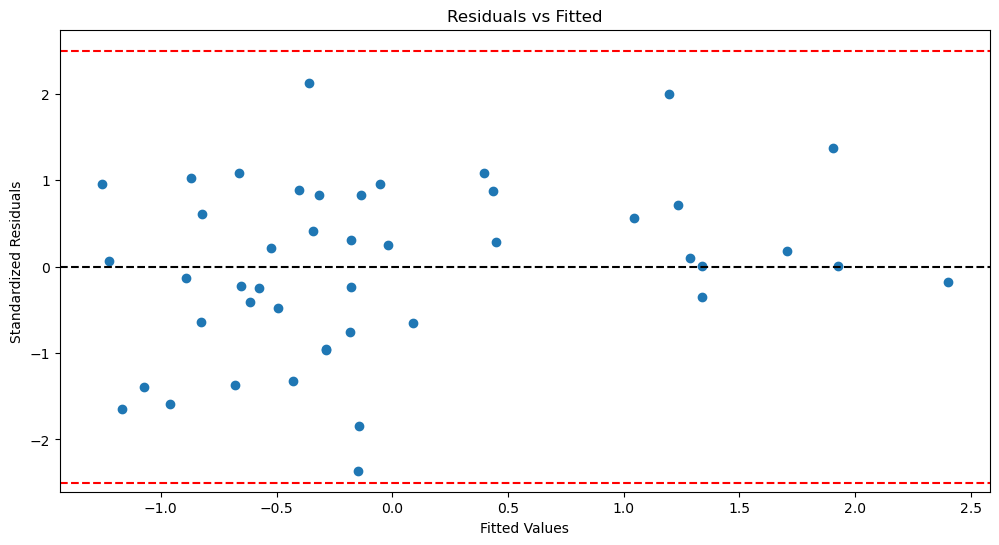

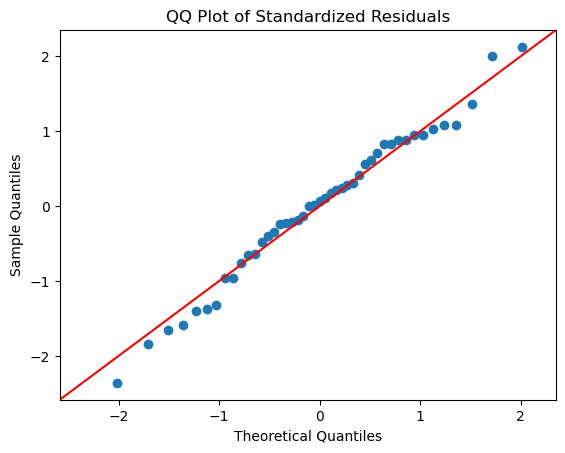

In [308]:
# Visualize residuals and QQ plot
resid_vis(lmm_hr_result)

In [103]:
# Random effects covariance matrix
print("Random Effects Covariance Matrix:")
print(lmm_hr_result.cov_re)

# Standard deviation of random effects
print("\nRandom Effects Std Devs:")
print(lmm_hr_result.random_effects)


Random Effects Covariance Matrix:
                                  ID  session[T.Exam]  \
ID                        218.890359       121.957041   
session[T.Exam]           121.957041       406.739765   
session[T.Resting state] -110.008504      -271.369942   

                          session[T.Resting state]  
ID                                     -110.008504  
session[T.Exam]                        -271.369942  
session[T.Resting state]                185.552615  

Random Effects Std Devs:
{'vrt02': ID                          11.627328
session[T.Exam]              8.608551
session[T.Resting state]    -7.164525
dtype: float64, 'vrt03': ID                          11.374100
session[T.Exam]             24.362464
session[T.Resting state]   -16.893459
dtype: float64, 'vrt05': ID                         -18.778994
session[T.Exam]             -9.884220
session[T.Resting state]     9.078989
dtype: float64, 'vrt06': ID                         -5.798418
session[T.Exam]             8.26667

Calculate EMMEANS


In [450]:
get_emmeans(lmm_hr_result, grid, "HR")
grid.head()

,session,group,instrument_type,gender,HR_emmean,HR_emmean_SE,HR_emmean_lowerCI,HR_emmean_upperCI
0,Exam,exp,2,1,120.703551,12.036374,97.112691,144.294411
1,Exam,exp,2,2,127.013452,11.173554,105.113688,148.913216
2,Exam,exp,1,1,130.655710,12.394843,106.362263,154.949156
3,Exam,exp,1,2,136.965610,11.413208,114.596134,159.335086
4,Exam,ctr,2,1,118.642680,13.886437,91.425764,145.859597


Post-hoc tests

In [ ]:
########## REUSABLE ##########
# Fetch coefficients' names
coef_names = list(lmm_hr_result.fe_params.index)
# Create empty dictionary for storing contrast names 
contrast_dict = {}

# Create contrast tables
c1 = np.zeros(len(coef_names))
c1[coef_names.index('C(session)[T.Exam]')] = 1
contrast_dict["Main effect beween baseline and exam: "] = c1

# Run contrast tests
contrasts_hr = test_contrasts(lmm_hr_result, contrast_dict, 0.05)

Visualize subject-level trajectories over sessions for heart rate

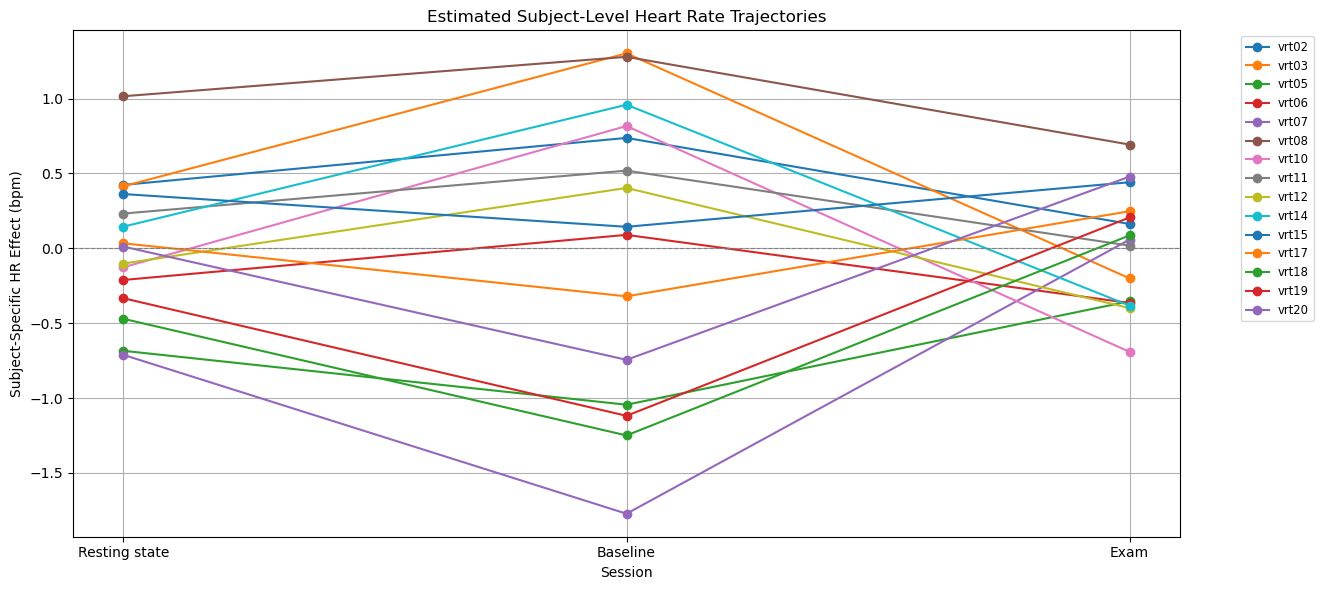

In [237]:
############################ NOT NECESSARY ############################
# Define session names 
sessions = ["Resting state", "Baseline", "Exam"]
x_vals = range(len(sessions))

# Plot
plt.figure(figsize=(12, 6))

for subj_id, re in lmm_hr_result.random_effects.items():
    # Random intercept and session slopes
    intercept = re.get('ID', 0)
    exam_slope = re.get('session[T.Exam]', 0)
    rest_slope = re.get('session[T.Resting state]', 0)
    
    # Predicted values relative to intercept
    y_vals = [intercept, intercept + exam_slope, intercept + rest_slope]
    
    plt.plot(x_vals, y_vals, marker='o', label=subj_id)

# Plot
plt.xticks(x_vals, sessions)
plt.xlabel("Session")
plt.ylabel("Subject-Specific HR Effect (bpm)")
plt.title("Estimated Subject-Level Heart Rate Trajectories")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.show()


# Try instead with pymer4

Pymer4, and rpy2 and R are not working for some reason, probably a corrupted R installation, or a Path problem, maybe unicode issues. Anyway, it doesn't worth the hassle I move the modeling part to Google Colab.

In [29]:
# Save hrv and rrv dataframes for external use
hrv_data5.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/hrv_data_colab.csv")
rrv_data4.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/rrv_data_colab.csv")

#### SDNN

In [127]:
# Conduct the LMM model for SDNN
lmm_sdnn = mixedlm(
        "HRV_SDNN ~ C(session) * C(group) + C(instrument_type) + C(gender)",  # Fixed effects
        data=hrv_data3,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for session within each subject
)

lmm_sdnn_result = lmm_sdnn.fit(method="powell", # optimization method for noisy and low signal quality
                               disp=True, maxiter=1000)

lmm_sdnn_result.summary()

Optimization terminated successfully.
         Current function value: 5.456558
         Iterations: 5
         Function evaluations: 345


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                           MixedLM              Dependent Variable:              HRV_SDNN 
No. Observations:                45                   Method:                          REML     
No. Groups:                      15                   Scale:                           6595.8845
Min. group size:                 3                    Log-Likelihood:                  -245.5451
Max. group size:                 3                    Converged:                       Yes      
Mean group size:                 3.0                                                            
------------------------------------------------------------------------------------------------
                                                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------
Intercept                                         -72.252  125.360 -0.576 0.564 -317.953 173.450
C(session)[T.Exam]                                 84.008   78.881  1.065 0.287  -70.595 238.611
C(session)[T.Resting state]                      -146.193   62.236 -2.349 0.019 -268.174 -24.212
C(group)[T.exp]                                   -33.967  104.954 -0.324 0.746 -239.673 171.739
C(instrument_type)[T.2]                           128.726   80.986  1.589 0.112  -30.005 287.456
C(gender)[T.2]                                    384.002   96.538  3.978 0.000  194.791 573.212
C(session)[T.Exam]:C(group)[T.exp]               -102.643  101.835 -1.008 0.313 -302.235  96.949
C(session)[T.Resting state]:C(group)[T.exp]       115.220   80.347  1.434 0.152  -42.257 272.697
ID Var                                          32767.933                                       
ID x session[T.Exam] Cov                       -18561.936                                       
session[T.Exam] Var                             24141.226                                       
ID x session[T.Resting state] Cov                5430.282                                       
session[T.Exam] x session[T.Resting state] Cov   8089.219                                       
session[T.Resting state] Var                    10048.521                                       
================================================================================================

"""

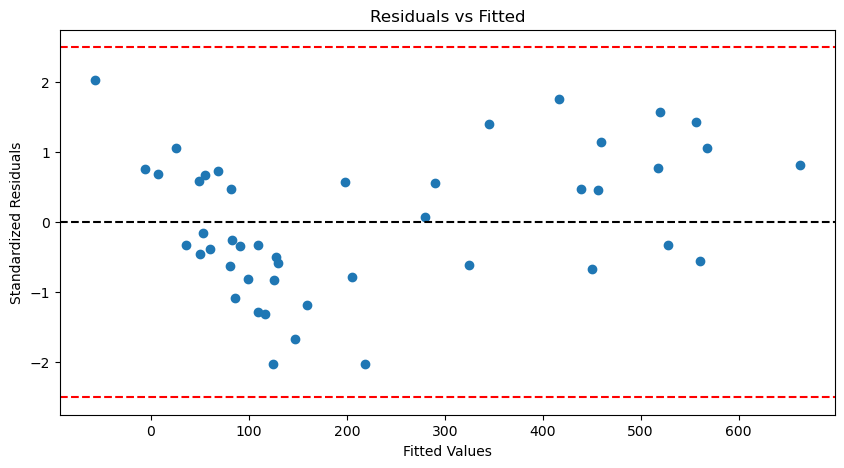

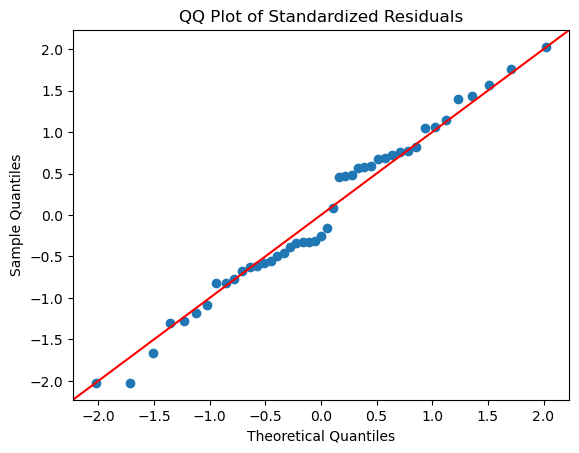

In [123]:
# Visualize residuals
sdnn_residuals = res_visual(model_result=lmm_sdnn_result)
sdnn_residuals

# Calculate covariance matrix

# Storing former unused code cells and model tryouts for reference and backup

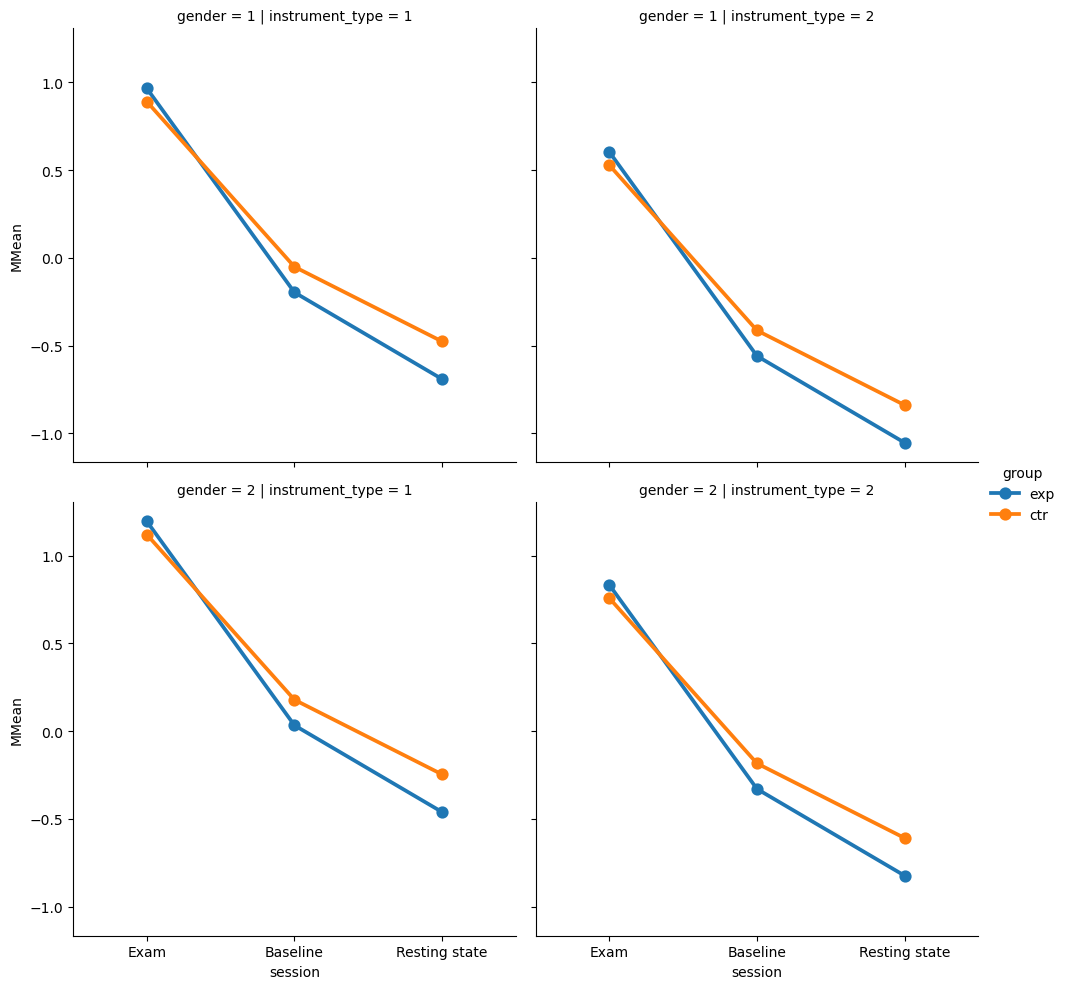

In [330]:
sns.catplot(data=grid, x="session", y="MMean", hue="group", kind="point", col="instrument_type", row="gender")
plt.show()

In [46]:
# Transpose p-values dataframe
lmm_p_values_df_T = lmm_p_values_df.transpose()

# Inspect the new df
lmm_p_values_df_T

# Save table
lmm_p_values_df_T.to_excel("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/lmm_p_values.xlsx", index=True)



### Calculate effect sizes for each metric

In [17]:
# List of metrics to compare
effsize_metrics = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF", "RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]

# Subset df for the exam session
exam_only = combined_visual2[combined_visual2["session"] == "Exam"]

In [39]:
# Compute effect sizes
effsizes = {}

# Define groups
exam_group1 = exam_only[exam_only["group"] == "exp"]
exam_group2 = exam_only[exam_only["group"] == "ctr"]

# Calculate effect sizes
for metric in effsize_metrics:
    # Select the metric column for each group
    group1_metric = exam_group1[metric]
    group2_metric = exam_group2[metric]
    # Compute effect size
    effsize = pg.compute_effsize(group1_metric, group2_metric, eftype="cohen")
    effsizes[metric] = effsize

effect_sizes = pd.DataFrame(effsizes, index=["Cohen's d"])

In [64]:
# See the results
effect_sizes

,heart_rate,HRV_SDNN,HRV_SD1SD2,HRV_LFHF,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_LFHF
Cohen's d,0.632536,-0.483948,-0.47609,0.349718,0.759815,-0.475349,-0.399157,-0.675193


### Power analysis

In [63]:
# Create power analysis for SDBB and SDNN
import statsmodels.stats.power as smp

In [71]:
# Calculate minimum sample size for SDNN
# Define parameters
effect_size_SDNN = effect_sizes.loc["Cohen's d", ["HRV_SDNN"]].item()  # Using the already computed Cohen's d: effect_sizes
alpha = 0.05  # Typical significance level
power = 0.8   # Desired power level (80%)
num_groups = 2  # Number of groups (control and experimental)

# Calculate the required sample size per group (assuming a balanced design)
analysis_SDNN = smp.FTestAnovaPower()
group_size_SDNN = analysis_SDNN.solve_power(effect_size=effect_size_SDNN, alpha=alpha, power=power, k_groups=num_groups)
sample_size_SDNN = group_size_SDNN * num_groups

print("To have a significant SDNN difference between groups, the following sample sizes are required: ")
print(f"Required sample size per group: {group_size_SDNN:.2f}")
print(f"Total required sample size: {sample_size_SDNN:.2f}")

To have a significant SDNN difference between groups, the following sample sizes are required: 
Required sample size per group: 35.54
Total required sample size: 71.08


In [74]:
# Calculate minimum sample size for RRV RMSSD
# Define parameters
effect_size_SDBB = effect_sizes.loc["Cohen's d", ["RRV_RMSSD"]].item()  # You can estimate this from previous research or pilot data
alpha = 0.05  # Typical significance level
power = 0.8   # Desired power level (80%)
num_groups = 2  # Number of groups (control and experimental)

# Calculate the required sample size per group (assuming a balanced design)
analysis_RMSSD = smp.FTestAnovaPower()
group_size_RMSSD = analysis_RMSSD.solve_power(effect_size=effect_size_SDBB, alpha=alpha, power=power, k_groups=num_groups)
sample_size_RMSSD = group_size_RMSSD * num_groups

print("To have a significant SDBB difference between groups, the following sample sizes are required: ")
print(f"Required sample size per group: {group_size_RMSSD:.2f}")
print(f"Total required sample size: {sample_size_RMSSD:.2f}")

To have a significant SDBB difference between groups, the following sample sizes are required: 
Required sample size per group: 36.76
Total required sample size: 73.52


### Calculating age, number of years of music experience and number of concerts

In [16]:
# Caclulate age
import numpy as np
age_list = [23, 20, 21, 23, 23, 19, 19, 19, 20, 21, 20, 20, 21, 22, 20]
print(np.mean(age_list).round(2))
print(np.std(age_list).round(2))
print(len(age_list))

20.73
1.39
15


In [18]:
# Calculate experience
experience_list = [18, 16, 15, 16, 15, 14, 12, 12, 7, 14, 13, 14, 11, 16, 13]
print(np.mean(experience_list).round(2))
print(np.std(experience_list).round(2))
print(len(experience_list))

13.73
2.54
15


In [20]:
# Calculate number of concerts
concerts_list = [8, 10, 8, 5, 5, 8, 2, 11, 4, 3, 5, 10, 5, 8, 3]
print(np.mean(concerts_list))
print(np.std(concerts_list))
print(len(concerts_list))

6.333333333333333
2.748737083745107
15


### Comparing LF and HF band powers

In [4]:
combined_df.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'session', 'quality', 'heart_rate', 'ID', 'RSP_Rate_Mean',
       'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF', 'RRV_LF', 'RRV_HF',
       'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group', 'instrument_type'],
      dtype='object')

In [67]:
# Create dataframe for HRV LF and HF comparison
data_freq = combined_df[["HRV_LF", "HRV_HF", "session", "ID", "group", "instrument_type"]]

# Inspect the new df
data_freq.head()

,HRV_LF,HRV_HF,session,ID,group,instrument_type
0,0.001682,0.001836,exam,vrt02,1,2
1,0.003896,0.004526,exam,vrt03,1,2
2,0.038480,0.031706,exam,vrt05,2,2
3,0.001788,0.000565,exam,vrt06,1,1
4,0.039150,0.036763,exam,vrt07,1,1


In [68]:
data_freq["session"].value_counts()

exam    15
bl      15
rs      15
Name: session, dtype: int64

In [69]:
# Reshape the DataFrame to long format using pd.melt
freq_long = pd.melt(data_freq, id_vars=["ID", "session", "group"], value_vars=['HRV_LF', 'HRV_HF'],
                  var_name='HRV_Type', value_name='HRV_Value')

# Inspect the data
freq_long.head()

,ID,session,group,HRV_Type,HRV_Value
0,vrt02,exam,1,HRV_LF,0.001682
1,vrt03,exam,1,HRV_LF,0.003896
2,vrt05,exam,2,HRV_LF,0.038480
3,vrt06,exam,1,HRV_LF,0.001788
4,vrt07,exam,1,HRV_LF,0.039150


In [73]:
# Remapping binary variables' numeric values to strings 
freq_long2 = freq_long.copy()
freq_long2["group"] = freq_long["group"].map({1: "exp", 2: "ctr"})
freq_long3 = freq_long2.copy()
freq_long3["session"] = freq_long2["session"].map({"rs": "Resting state", "bl": "Baseline", "exam": "Exam"})

# Ensure the session has the correct order
freq_long3['session'] = pd.Categorical(freq_long3['session'], categories=['Resting state', 'Baseline', 'Exam'], ordered=True)


freq_long3["session"].value_counts()

Resting state    30
Baseline         30
Exam             30
Name: session, dtype: int64

C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_2844\4225350686.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=freq_long3, x='session', y='HRV_Value', hue='group',


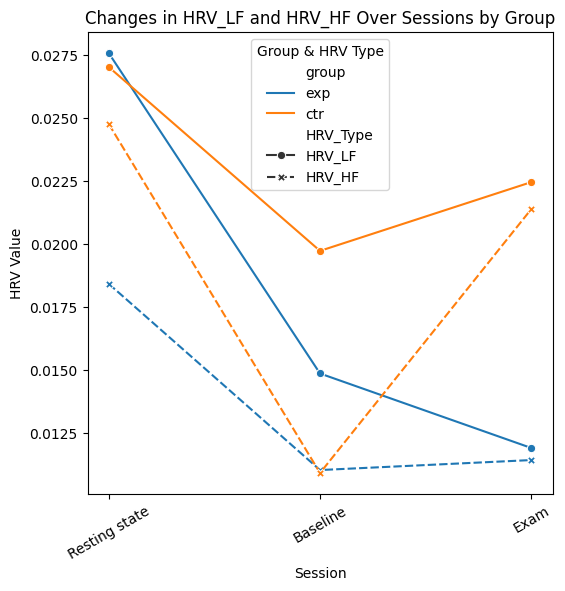

In [75]:
# Create the figure
plt.figure(figsize=(6, 6))

# Plot HRV data using the long format
sns.lineplot(data=freq_long3, x='session', y='HRV_Value', hue='group', 
             style='HRV_Type', markers=True,
             ci=None, errorbar="sd")

# Customize labels and title
plt.xlabel("Session")
plt.ylabel("HRV Value")
plt.title("Changes in HRV_LF and HRV_HF Over Sessions by Group")

# Show the plot
plt.xticks(rotation=30)
plt.legend(title="Group & HRV Type")
plt.show()

In [76]:
data_freq.head()

,HRV_LF,HRV_HF,session,ID,group,instrument_type
0,0.001682,0.001836,exam,vrt02,1,2
1,0.003896,0.004526,exam,vrt03,1,2
2,0.038480,0.031706,exam,vrt05,2,2
3,0.001788,0.000565,exam,vrt06,1,1
4,0.039150,0.036763,exam,vrt07,1,1


In [83]:
# Drop Resting state level of the session variable to simplify the model
data_freq2 = data_freq[data_freq["session"] != "rs"] 

In [84]:
data_freq2["session"].value_counts()

exam    15
bl      15
Name: session, dtype: int64

In [100]:
# Conduct an LMM on HF
lmm_hf = smf.mixedlm(
        "HRV_HF ~ session * group",  # Fixed effects
        data=data_freq2,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

# Fit the model
lmm_hf_results = lmm_hf.fit()

# Show model summary
lmm_hf_results.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    HRV_HF 
No. Observations:      30         Method:                REML   
No. Groups:            15         Scale:                 0.0001 
Min. group size:       2          Log-Likelihood:        73.9035
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.011    0.011  1.020 0.308 -0.010  0.033
session[T.exam]       -0.010    0.009 -1.079 0.281 -0.027  0.008
group                 -0.000    0.007 -0.016 0.987 -0.015  0.014
session[T.exam]:group  0.010    0.006  1.666 0.096 -0.002  0.022
ID Var                 0.000    0.011                           
================================================================

"""

In [478]:
###################### FORMER TEST ###################
# Get parameter names and their order
params = lmm_hr_result.params.index.tolist()
print("params: ", params)

n_fe = lmm_hr_result.k_fe
fe_params = lmm_hr_result.params.index[:n_fe]
print("fixed effects params: ", fe_params)

contrast = np.zeros(n_fe)
contrast[list(fe_params).index('C(session)[T.Exam]')] = 1  # Exam - Baseline

ttest_result = lmm_hr_result.t_test(contrast.reshape(1, -1))
print(ttest_result.summary())

params:  ['Intercept', 'C(session)[T.Exam]', 'C(session)[T.Resting state]', 'C(group)[T.exp]', 'C(instrument_type)[T.2]', 'C(gender)[T.2]', 'C(session)[T.Exam]:C(group)[T.exp]', 'C(session)[T.Resting state]:C(group)[T.exp]', 'ID Var', 'ID x session[T.Exam] Cov', 'session[T.Exam] Var', 'ID x session[T.Resting state] Cov', 'session[T.Exam] x session[T.Resting state] Cov', 'session[T.Resting state] Var']
fixed effects params:  Index(['Intercept', 'C(session)[T.Exam]', 'C(session)[T.Resting state]',
       'C(group)[T.exp]', 'C(instrument_type)[T.2]', 'C(gender)[T.2]',
       'C(session)[T.Exam]:C(group)[T.exp]',
       'C(session)[T.Resting state]:C(group)[T.exp]'],
      dtype='object')
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            25.8333      9.730      2.655      0.008       6.762   

In [119]:
freq_long4 = freq_long3[freq_long3["session"] != "Resting state"]

In [120]:
freq_long4["session"].value_counts()

Baseline         30
Exam             30
Resting state     0
Name: session, dtype: int64

In [121]:
freq_long4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 74
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         60 non-null     object  
 1   session    60 non-null     category
 2   group      60 non-null     object  
 3   HRV_Type   60 non-null     object  
 4   HRV_Value  60 non-null     float64 
dtypes: category(1), float64(1), object(3)
memory usage: 2.5+ KB


In [128]:
# Compare LF and HF values
# Conduct an LMM on HF
lmm_lfhf = smf.mixedlm(
        "HRV_Value ~ session * HRV_Type + group", # Fixed effects
        data=freq_long3,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for 'session' within each subject
    )

# Fit the model
lmm_lfhf_results = lmm_lfhf.fit()

# Show model summary
lmm_lfhf_results.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                       MixedLM          Dependent Variable:          HRV_Value
No. Observations:            90               Method:                      REML     
No. Groups:                  15               Scale:                       0.0000   
Min. group size:             6                Log-Likelihood:              257.9229 
Max. group size:             6                Converged:                   Yes      
Mean group size:             6.0                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.025    0.006  4.362 0.000  0.014  0.036
session[T.Baseline]                       -0.010    0.003 -2.872 0.004 -0.017 -0.003
session[T.Exam]                           -0.006    0.003 -1.886 0.059 -0.011  0.000
HRV_Type[T.HRV_LF]                         0.006    0.003  2.521 0.012  0.001  0.011
group[T.exp]                              -0.007    0.006 -1.171 0.242 -0.018  0.005
session[T.Baseline]:HRV_Type[T.HRV_LF]    -0.001    0.004 -0.160 0.873 -0.008  0.006
session[T.Exam]:HRV_Type[T.HRV_LF]        -0.006    0.004 -1.584 0.113 -0.013  0.001
ID Var                                     0.000    0.018                           
ID x session[T.Baseline] Cov              -0.000    0.011                           
session[T.Baseline] Var                    0.000    0.008                           
ID x session[T.Exam] Cov                  -0.000    0.008                           
session[T.Baseline] x session[T.Exam] Cov  0.000    0.005                           
session[T.Exam] Var                        0.000    0.005                           
====================================================================================

"""

### Comparing genders

In [140]:
combined_visual2[["gender", "ID"]].head()

,gender,ID
0,1,vrt02
1,1,vrt03
2,2,vrt05
3,2,vrt06
4,2,vrt07


#### gender: 1 = male, 2 = female

In [142]:
combined_visual2['gender'] = combined_visual2['gender'].astype('category')

In [155]:
# List of metrics you want to analyze
metrics_hrv = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF"]

metrics_rrv = ["RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]
# Empty dictionary to store the results
p_values = {}

"""
    I had to create two separate dataframes to loop through, because vrt06 had no respiratory data
    and I had to drop her from the RRV analysis
"""
# Drop vrt06 for RRV analysis
combined_rrv = combined_visual2[combined_visual2["ID"] != "vrt06"]

# Loop through each HRV  metric
for metric in metrics_hrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_hrv = smf.mixedlm(
        f"{metric} ~ session * group + instrument_type + gender",  # Fixed effects
        data=combined_visual2,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_hrv_result = lmm_hrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
    p_values[metric] = {
        'session': lmm_hrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_hrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_hrv_result.pvalues['instrument_type[T.2]'].round(2),
        "gender": lmm_hrv_result.pvalues["gender[T.2]"].round(2),
        'session:group': lmm_hrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }


# Convert the results into a DataFrame for easier viewing
lmm_p_values_df = pd.DataFrame(p_values)


Analyzing heart_rate...
Analyzing HRV_SDNN...
Analyzing HRV_SD1SD2...
Analyzing HRV_LFHF...


C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [156]:
lmm_p_values_df

,heart_rate,HRV_SDNN,HRV_SD1SD2,HRV_LFHF
session,"[0.93, 0.78]","[0.38, 0.08]","[0.15, 0.92]","[0.17, 0.11]"
group,0.89,0.7,0.88,0.61
instrument_type,0.14,0.45,0.2,0.06
gender,0.02,0.01,0.0,0.01
session:group,"[0.15, 0.64]","[0.51, 0.26]","[0.36, 0.65]","[0.39, 0.42]"
